In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_selected = pd.read_csv('rusentiment_preselected_posts.csv')
df_random = pd.read_csv('rusentiment_random_posts.csv')
df_test = pd.read_csv('rusentiment_test.csv')

In [10]:
df_train = pd.concat((df_selected, df_random))

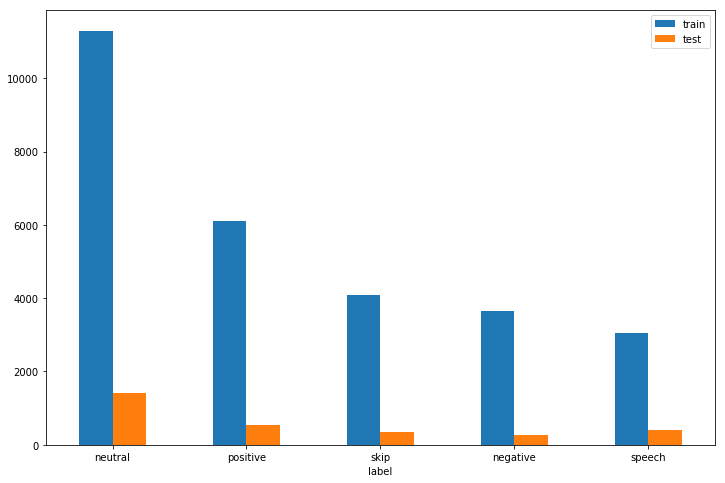

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'train': df_train.groupby('label').text.count(), 'test':df_test.groupby('label').text.count()})
freq.sort_values(by='train', ascending=False).plot.bar(rot=0, ax=ax);

In [12]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Text in string format', pos=True):
    # –µ—Å–ª–∏ —á–∞—Å—Ç–µ—Ä–µ—á–Ω—ã–µ —Ç—ç–≥–∏ –Ω–µ –Ω—É–∂–Ω—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, –∏—Ö –Ω–µ—Ç –≤ –º–æ–¥–µ–ª–∏), –≤—ã—Å—Ç–∞–≤—å—Ç–µ pos=False
    # –≤ —ç—Ç–æ–º —Å–ª—É—á–∞–µ –Ω–∞ –≤—ã—Ö–æ–¥ –±—É–¥—É—Ç –ø–æ–¥–∞–Ω—ã —Ç–æ–ª—å–∫–æ –ª–µ–º–º—ã

    # –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Ç–µ–∫—Å—Ç, –ø–æ–ª—É—á–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç –≤ —Ñ–æ—Ä–º–∞—Ç–µ conllu:
    processed = pipeline.process(text)

    # –ø—Ä–æ–ø—É—Å–∫–∞–µ–º —Å—Ç—Ä–æ–∫–∏ —Å–æ —Å–ª—É–∂–µ–±–Ω–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # –∏–∑–≤–ª–µ–∫–∞–µ–º –∏–∑ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞ –ª–µ–º–º—É –∏ —Ç—ç–≥
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]
    result = []
    for t in tagged:
        if (len(t.split('_')) == 2):
            lemma, tag = t.split('_')
            # —É–±–∏—Ä–∞–µ–º —á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã–µ –∏ –≤—Å–µ –∑–Ω–∞–∫–∏ –ø—É–Ω–∫—Ç—É–∞—Ü–∏–∏ –∫—Ä–æ–º–µ —Å–∫–æ–±–æ–∫
            if tag == 'NUM' or (tag == 'PUNCT' and lemma not in ['(', ')']):
                continue
            if pos:
                result.append(lemma + '_' + tag)
            else:
                result.append(lemma)
    return result

In [13]:
df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

df_train = df_train[~df_train.lemmatized_text.isnull()]
df_test = df_test[~df_test.lemmatized_text.isnull()]

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

array(['–ø—Ä–æ—Ä–≤–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–π –±–ª–æ–∫–∞–¥–∞ –∏–∑–Ω—É—Ç—Ä–∏',
       '–Ω–∏–∫–æ–≥–¥–∞ —É —è –Ω–µ –±—ã—Ç—å –æ–¥–∏–Ω –ø—Ä–∏–ª–æ–∂–µ–Ω–∏–µ –¥–ª—è –≤—Å–µ –≤ —Ç–æ–ø–∫–∞ —ç—Ç–æ—Ç —É—â–µ—Ä–±–Ω—ã–π —É–Ω–∏–≤–µ—Ä—Å–∞–ª—å–Ω–æ—Å—Ç—å',
       '–∫—É—Ä–∏-—å —Ç—ã –Ω–µ —É–∫—É—Å–∏—Ç—å –∑–ª–æ–π —Å–æ–±–∞–∫–∞ –ø–æ—Ç–æ–º—É —á—Ç–æ —Ç—ã –≤–æ–Ω—è—Ç—å ,–∫—É—Ä–∏-—å —Ç—ã –Ω–µ –æ–≥—Ä–∞–±–∏—Ç—å ,—Ç–∞–∫ –∫–∞–∫ —Ç—ã –∏—Å–ø—É–≥–∞—Ç—å –≥—Ä–∞–±–∏—Ç–µ–ª—å –æ—Ç–≤—Ä–∞—Ç–∏—Ç–µ–ª—å–Ω—ã–π –≥—Ä–æ–º–∫–∏–π –∫–∞—à–µ–ª—å –∫—É—Ä–∏—Ç—å –∏ —Ç—ã –Ω–µ —É–º–∏—Ä–∞—Ç—å –æ—Ç —Å—Ç–∞—Ä–æ—Å—Ç—å –ø—Ä–æ—Å—Ç–æ –Ω–µ –¥–æ–∂–∏—Ç—å –¥–æ –æ–Ω–∞ –¥–∞–º–∞ –∏ –≥–æ—Å–ø–æ–¥–∏–Ω –∫—É—Ä–∏—Ç—å –Ω–∞—Å–º–µ—Ä—Ç—å',
       ...,
       '—É—Ä –∑–æ–ª–æ—Ç–æ –¥–∞–≤–∞—Ç—å –±–µ—Å–ø–ª–∞—Ç–Ω–æ –Ω–∞–ø–∏—Å–∞—Ç—å —ç—Ç–æ –≤ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –∏ –∏–¥—Ç–∏ –∫ —Å–∞—à–∞ –∏–ª–∏ –º–∞—à–∞ –≤—ã–±—Ä–∞—Ç—å —Å–∫–æ–ª—å–∫–æ –Ω–∞–¥–æ –∏ —ç—Ç–æ –ø—Ä–∞–≤–¥–∞',
       '—Å –ø—Ä–∞–∑–¥–Ω–∏–∫ –∫—Å—é–Ω—å –∂–µ–Ω—Å–∫–∏–π —Å—á–∞—Å—Ç—å–µ —Ç—ã –≤—ã–±–∏—Ä–∞—Ç—å –ª—é–±–æ–π',
   

In [16]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import expon

skf = StratifiedKFold(n_splits=5, random_state=42)
pipe = Pipeline([('tfidf',TfidfVectorizer(sublinear_tf=True)), ('classifier', MultinomialNB())])
param_grid = [
              {'classifier':[LogisticRegression(penalty='l1', dual=False)],
               'tfidf__ngram_range':[(1,1),(1,2)],
               'classifier__C': expon(scale=5).rvs(size=5)}, 
              {'classifier':[MultinomialNB(fit_prior=True,class_prior=None)],
              'tfidf__ngram_range':[(1,1),(1,2)],
              'tfidf__min_df':np.arange(3,6,1),
              'classifier__alpha': expon(scale=1).rvs(size=3), 
              },
              { 'classifier':[LinearSVC(penalty='l1', dual=False)],
                'tfidf__ngram_range':[(1,1),(1,2)],
               'classifier__C': expon(scale=2).rvs(size=4)
              }]

gr = GridSearchCV(pipe, param_grid, cv=skf, verbose=0, n_jobs=-1)
gr_model = gr.fit(X_train, y_train)


gr_model.best_params_, gr_model.best_score_

/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 8.07 s, sys: 501 ms, total: 8.57 s
Wall time: 2h 10min 8s


In [84]:
result = gr_model.cv_results_

In [85]:
rows = list ()
for model in result['params']:
    row = []
    for key, val in model.items():
        if key=='classifier':
            v_str = (val.__str__())
            row.append(v_str [ : v_str.find('(')])
        else:
            param = key.__str__()
            param = param [ param.find('__')+2 :]
            row.append(param + ' = ' + val.__str__())
    rows.append(row)

df = pd.DataFrame(rows)
df['score'] = result['mean_test_score']
df['time'] = result['mean_fit_time']

df = df.sort_values(by=['score'], ascending=False)
df

0                           1                     2  \
0   LogisticRegression      C = 2.6644453551636724  ngram_range = (1, 1)   
1   LogisticRegression      C = 2.6644453551636724  ngram_range = (1, 2)   
35           LinearSVC       C = 1.407318441083937  ngram_range = (1, 2)   
31           LinearSVC      C = 1.3888592741266443  ngram_range = (1, 2)   
5   LogisticRegression       C = 5.726735875556365  ngram_range = (1, 2)   
7   LogisticRegression       C = 5.838138457911631  ngram_range = (1, 2)   
8   LogisticRegression      C = 1.0037062124097704  ngram_range = (1, 1)   
30           LinearSVC      C = 1.3888592741266443  ngram_range = (1, 1)   
34           LinearSVC       C = 1.407318441083937  ngram_range = (1, 1)   
4   LogisticRegression       C = 5.726735875556365  ngram_range = (1, 1)   
6   LogisticRegression       C = 5.838138457911631  ngram_range = (1, 1)   
33           LinearSVC       C = 2.235455744922418  ngram_range = (1, 2)   
9   LogisticRegression      C = 1.0037062124097704  ngram_range = (1, 2)   
29           LinearSVC        C = 2.25814998448718  ngram_range = (1, 2)   
25       MultinomialNB  alpha = 0.5414886666190056            min_df = 4   
19       MultinomialNB   alpha = 0.546743819239456            min_df = 4   
21       MultinomialNB   alpha = 0.546743819239456            min_df = 5   
27       MultinomialNB  alpha = 0.5414886666190056            min_df = 5   
11       MultinomialNB  alpha = 0.1019409118295453            min_df = 3   
13       MultinomialNB  alpha = 0.1019409118295453            min_df = 4   
15       MultinomialNB  alpha = 0.1019409118295453            min_df = 5   
23       MultinomialNB  alpha = 0.5414886666190056            min_df = 3   
17       MultinomialNB   alpha = 0.546743819239456            min_df = 3   
10       MultinomialNB  alpha = 0.1019409118295453            min_df = 3   
2   LogisticRegression      C = 0.5837185541904334  ngram_range = (1, 1)   
28           LinearSVC        C = 2.25814998448718  ngram_range = (1, 1)   
32           LinearSVC       C = 2.235455744922418  ngram_range = (1, 1)   
26       MultinomialNB  alpha = 0.5414886666190056            min_df = 5   
22       MultinomialNB  alpha = 0.5414886666190056            min_df = 3   
20       MultinomialNB   alpha = 0.546743819239456            min_df = 5   
16       MultinomialNB   alpha = 0.546743819239456            min_df = 3   
24       MultinomialNB  alpha = 0.5414886666190056            min_df = 4   
12       MultinomialNB  alpha = 0.1019409118295453            min_df = 4   
18       MultinomialNB   alpha = 0.546743819239456            min_df = 4   
14       MultinomialNB  alpha = 0.1019409118295453            min_df = 5   
3   LogisticRegression      C = 0.5837185541904334  ngram_range = (1, 2)   

                       3     score         time  
0                   None  0.596428     3.253181  
1                   None  0.594550     8.899513  
35                  None  0.588596    15.185530  
31                  None  0.588348    13.758476  
5                   None  0.587604  1814.452355  
7                   None  0.586895  1913.270982  
8                   None  0.586328     4.083070  
30                  None  0.584662     8.647488  
34                  None  0.583670     6.433576  
4                   None  0.582961  1080.744147  
6                   None  0.582678   891.371108  
33                  None  0.580126    19.889336  
9                   None  0.578921    12.167443  
29                  None  0.578921    23.851028  
25  ngram_range = (1, 2)  0.578780     5.057993  
19  ngram_range = (1, 2)  0.578638     5.040094  
21  ngram_range = (1, 2)  0.578496     4.981551  
27  ngram_range = (1, 2)  0.578390     4.813597  
11  ngram_range = (1, 2)  0.577645     5.131175  
13  ngram_range = (1, 2)  0.576937     5.112743  
15  ngram_range = (1, 2)  0.576653     5.089112  
23  ngram_range = (1, 2)  0.576193     5.043577  
17  ngram_range = (1, 2)  0.576051     5.081922  
10  ngra

–õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è –Ω–∞ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Ä–∞–±–æ—Ç–∞–µ—Ç —á—É—Ç—å –ª—É—á—à–µ SVC (–∏ –ø—Ä–∏ —ç—Ç–æ–º –±—ã—Å—Ç—Ä–µ–µ). –ü–∞—Ä–∞–º–µ—Ç—Ä ngram_range = (1, 2) –ø–æ—á—Ç–∏ –Ω–µ –¥–∞–µ—Ç –¥–ª—è –Ω–µ–µ —É–ª—É—á—à–µ–Ω–∏—è score, –Ω–æ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –≤—Ä–µ–º—è —Ä–∞–±–æ—Ç—ã –≤ —Ä–∞–∑—ã. –ï—Å–ª–∏ –≤–º–µ—Å—Ç–µ —Å ngram_range = (1, 2) –≤–∑—è—Ç—å –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –±–æ–ª—å—à–æ–π C (~6), —Ç–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è –ø–æ–¥—Å–∫–∞–∫–∏–≤–∞–µ—Ç –Ω–∞ –ø–∞—Ä—É –ø–æ—Ä—è–¥–∫–æ–≤. 

–ü—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è –∏ SVC —Å—á–∏—Ç–∞—é—Ç—Å—è –≥–æ—Ä–∞–∑–¥–æ –±—ã—Å—Ç—Ä–µ–µ, —á–µ–º –Ω–∞ –Ω–µ–æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö (—Ç–∞–∫ —á—Ç–æ –æ–±—â–µ–µ –≤—Ä–µ–º—è —Ä–∞–±–æ—Ç—ã –µ—â–µ –º–æ–∂–Ω–æ –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å). 35 –∫–æ–º–±–∏–Ω–∞—Ü–∏–π –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –ø—Ä–æ—Å—á–∏—Ç—ã–≤–∞–ª–∏—Å—å 2 —á–∞—Å–∞ 10 –º–∏–Ω—É—Ç.
–ü—Ä–∏ —ç—Ç–æ–º –≤—Ä–µ–º—è —Ä–∞–±–æ—Ç—ã –Ω–∞–∏–≤–Ω–æ–≥–æ –ë–∞–π–µ—Å–∞ –Ω–µ —Å–∏–ª—å–Ω–æ –º–µ–Ω—è–ª–æ—Å—å –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ (–≤ —Å—Ä–µ–¥–Ω–µ–º 5 —Å–µ–∫—É–Ω–¥ –¥–ª—è ngram_range = (1, 2) –∏ 2 —Å–µ–∫—É–Ω–¥—ã –¥–ª—è ngram_range = (1, 1), –≤—ã–∏–≥—Ä—ã—à –ø–æ score –æ–∫–∞–∑—ã–≤–∞–µ—Ç—Å—è –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–º). –≠—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏ –∞–ª–≥–æ—Ä–∏—Ç–º–∞.

–ù–∞–∏–≤–Ω—ã–π –ë–∞–π–µ—Å –ø—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö –≤—Å–µ–≥–¥–∞ –¥–∞–µ—Ç –º–µ–Ω—å—à–∏–π score, —á–µ–º –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è –∏ SVC, –Ω–æ –º–æ–∂–µ—Ç –æ—Ç—Ä–∞–±–æ—Ç–∞—Ç—å –±—ã—Å—Ç—Ä–µ–µ –∏—Ö.

In [83]:
df.iloc[list([0,1,2,4,5,6,7,8,14,15,18,27,28])] #–ë–æ–ª–µ–µ –Ω–∞–≥–ª—è–¥–Ω–∞—è —Ç–∞–±–ª–∏—Ü–∞ —Ä–∞–±–æ—Ç—ã –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π

0                           1                     2  \
0   LogisticRegression      C = 2.6644453551636724  ngram_range = (1, 1)   
1   LogisticRegression      C = 2.6644453551636724  ngram_range = (1, 2)   
35           LinearSVC       C = 1.407318441083937  ngram_range = (1, 2)   
5   LogisticRegression       C = 5.726735875556365  ngram_range = (1, 2)   
7   LogisticRegression       C = 5.838138457911631  ngram_range = (1, 2)   
8   LogisticRegression      C = 1.0037062124097704  ngram_range = (1, 1)   
30           LinearSVC      C = 1.3888592741266443  ngram_range = (1, 1)   
34           LinearSVC       C = 1.407318441083937  ngram_range = (1, 1)   
25       MultinomialNB  alpha = 0.5414886666190056            min_df = 4   
19       MultinomialNB   alpha = 0.546743819239456            min_df = 4   
11       MultinomialNB  alpha = 0.1019409118295453            min_df = 3   
26       MultinomialNB  alpha = 0.5414886666190056            min_df = 5   
22       MultinomialNB  alpha = 0.5414886666190056            min_df = 3   

                       3     score         time  
0                   None  0.596428     3.253181  
1                   None  0.594550     8.899513  
35                  None  0.588596    15.185530  
5                   None  0.587604  1814.452355  
7                   None  0.586895  1913.270982  
8                   None  0.586328     4.083070  
30                  None  0.584662     8.647488  
34                  None  0.583670     6.433576  
25  ngram_range = (1, 2)  0.578780     5.057993  
19  ngram_range = (1, 2)  0.578638     5.040094  
11  ngram_range = (1, 2)  0.577645     5.131175  
26  ngram_range = (1, 1)  0.573003     2.033073  
22  ngram_range = (1, 1)  0.572968     2.000002

In [87]:
gr_model.best_params_, gr_model.best_score_

({'classifier': LogisticRegression(C=2.6644453551636724, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
            solver='warn', tol=0.0001, verbose=0, warm_start=False),
  'classifier__C': 2.6644453551636724,
  'tfidf__ngram_range': (1, 1)},
 0.5964278120348714)

In [88]:
best_pipe = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
                              ('lr', LogisticRegression(C=2.6644453551636724, penalty='l1', dual=False))])

In [89]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Precision: 0.6662
Recall: 0.6822
f1-score: 0.6656


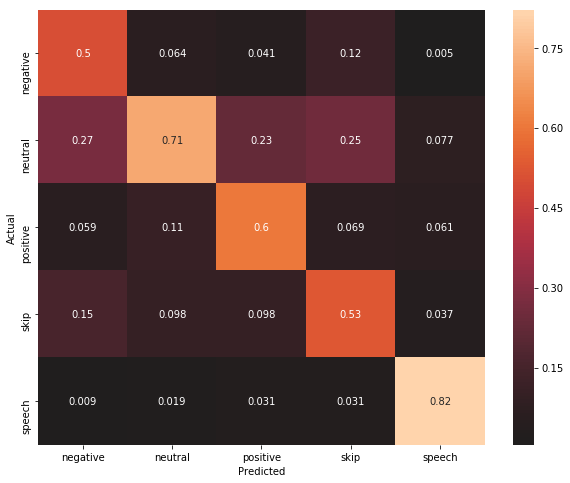

In [90]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [91]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

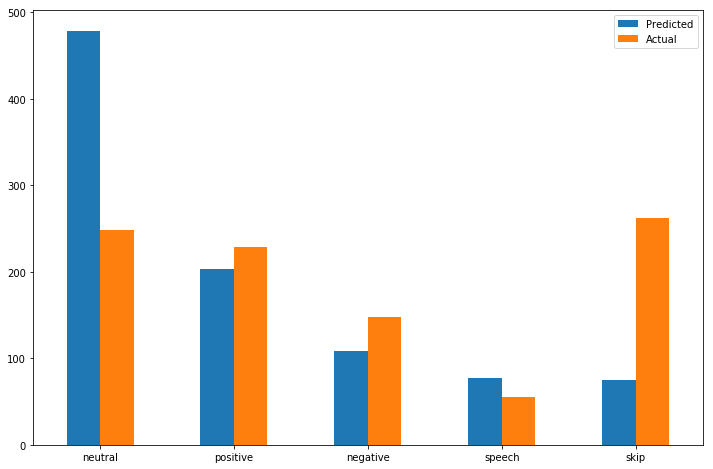

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [93]:
errors

text  \
3     –ú—ã –ø—Ä–æ—Å—Ç–æ —Å  [id12210212|–ï–ª–∏—Å–µ–µ–º]  –ø—Å–∏—Ö–∞–Ω—É–ª–∏ )...   
11                                         –°–µ–ª—Ñ–∏ –¥–Ω—è ))   
17    –Ø –Ω–µ –ø–∏—Å–∞–ª —Ç–∞–∫–æ–µ –æ—Å–∫–æ–±–ª–µ–Ω–∏–µ –≤—Å–µ–º!!!!\n–ú–µ–Ω—è, –≤–∏...   
18    ...–∏ —Ç–∞–∫ –Ω–∞—á–∞–ª–æ –º–∏–Ω–∏ –æ—Ç–ø—É—Å–∫–∞))–ò –Ω–æ–≤—ã—Ö –ø—Ä–∏–∫–ª—é—á–µ...   
19    –ö–∏–Ω—É–ª –≤ —á—Å –æ–±–∏–¥–µ–ª—Å—è —Ö–æ–ª–æ–ø –ø–æ–Ω—è–ª —á—Ç–æ –Ω–µ–¥–æ—Å—Ç–æ–∏–Ω ...   
21    –õ—É—á—à–µ –±—ã —É –¢–∞–Ω–∏ –Ω–µ –±—ã–ª–æ –Ω–∏–∫–∞–∫–æ–≥–æ –æ—Ä–≥–∞–∑–º–∞: —É—Å–ª—ã...   
25    –ø–æ –∫—Ä—É–≥—É, —Ç–≤–æ—é –ø–æ–¥—Ä—É–≥—É –ö–°–Æ–•–£....))))))–∞—Ö–∞—Ö–∞—Ö–∞–∞—Ö–∞—Ö   
26                                           –±–µ–∑ —Ç–µ–±—è_(   
27    —è –ø—Ä—ã–≥–Ω—É–ª –≤ –±–µ–∑–¥–Ω—É –∏–∑ —É—é—Ç–∞ –ø–æ—Ä–∞ –≥–æ—Ç–æ–≤–∏—Ç—å—Å—è –∫ –∑...   
29                                    –∞–º–º–º–º, –ö–∞—Ä–∏–Ω–∫–∞)))   
30                                   –ó 19 –≤–µ—Ä–µ—Å–Ω—è —Ç–µ–±–µ!   
31                                           –ú—ã —Ä–∞—Å—Ç–µ–º!   
33                               –Ω–∞ –∞–≤—É –ø—Ä—è–º–æ —Å–µ–π—á–∞–∞–∞—Å!   
43    –Ø –¥–æ–≤–µ—Ä—è—é –Ω–µ–º–Ω–æ–≥–∏–º. –ù–æ —ç—Ç–∏ –Ω–µ–º–Ω–æ–≥–∏–µ, –º–Ω–µ —Ä–µ–∞–ª—å...   
47                                       –ü–ò–î–û–† –≥–æ —Å–∫–∞–π–ø   
51                           –í–æ—Ç –∏ –º–æ—è –ø–µ—Ä–≤–∞—è –≤—ã—Å—Ç–∞–≤–∫–∞!   
52    –Ø –∂–∞–ª–æ–≤–∞–ª—Å—è –Ω–∞ –º—É—Å–æ—Ä –≤ —Ä–æ—Å—Ç–æ–≤—Å–∫–∏—Ö —Ä–æ—â–∞—Ö –∏ –ø–∞—Ä–∫...   
54    –ö—Ç–æ-—Ç–æ –∑–∞—Ö–æ–¥–∏—Ç –Ω–∞ –º–æ—é —Å—Ç—Ä–∞–Ω–∏—á–∫—É, —Å —É–º–∏–ª–µ–Ω–∏–µ–º —Å...   
60    –£–ª—ã–±–∞–π—Ç–µ—Å—å, –≥–æ—Å–ø–æ–¥–∞! \n–í—Å–µ –≥–ª—É–ø–æ—Å—Ç–∏ –º–∏—Ä–∞ –¥–µ–ª–∞—é...   
62    –° –î–ù–Å–ú –†–û–ñ–î–ï–ù–ò–Ø–Ø!!\n–ë–ï–ó–ì–†–ê–ù–ò–ß–ù–û–ì–û –ò –ù–ï–ò–°–ß–ï–†–ü–ê–ï...   
63    –ü–æ—Å–ª–µ 6-—Ç–∏ —á–∞—Å–æ–≤–æ–π –∑–∞–¥–µ—Ä–∂–∫–∏ –≤ –ë–∞–Ω–≥–∫–æ–∫–µ –∏ –≤—Ç–æ—Ä–æ...   
68                                          –ó–∞–±–æ–ªi–≤!(((   
70    - –ú–∞–¥–∞–º, —è –≤—á–µ—Ä–∞ —Å–ª—ã—à–∞–ª –≤–∞—à–µ –ø–µ–Ω–∏–µ...\n- –û, —á—Ç...   
71    –í—Å–µ—Ö, –∫—Ç–æ –ø—Ä–µ–¥–∞–ª ‚Äì –ø—Ä–æ—â–∞—é!\n–í—Å–µ–º, –∫—Ç–æ —É—à–µ–ª ‚Äì –∂...   
72                           –£–∂–∞—Å—Å—Å –∏–∑–≤—Ä–∞—â—ë–Ω–∞—è –¥–µ–≤–æ—á–∫–∞!   
76    –î–ª—è –∫–∞–∂–¥–æ–≥–æ —Ö—É–ª–∏–≥–∞–Ω–∞ –Ω–∞–π–¥–µ—Ç—Å—è —Ç–∞–∫–∞—è –¥–µ–≤—É—à–∫–∞, —Å...   
94    –ò —Å–Ω–æ–≤–∞ —è —Ä–∞–∑–æ—á–∞—Ä–æ–≤–∞–ª—Å—è –≤ –ª—é–¥—è—Ö. –°–µ–≥–æ–¥–Ω—è –≤–µ—á–µ—Ä...   
98    –°–µ–º—å —Å–µ–∫—Ä–µ—Ç–æ–≤ —Å—á–∞—Å—Ç–ª–∏–≤–æ–≥–æ —á–µ–ª–æ–≤–µ–∫–∞.\n\n1. –ù–µ –±...   
99    –í–æ—Ç —Ç–∞–∫ –º—ã –∏–∑ —Ç–æ—Ç–∞–ª–∏—Ç–∞—Ä–Ω–æ–≥–æ —Å–æ–≤–µ—Ç—Å–∫–æ–≥–æ –ø—Ä–æ—à–ª–æ–≥...   
102   –í—Å—ë —Ç–∞–∫ –∂–µ –ø—Ä–æ—Å—Ç–æ, –∏–¥–∏–æ—Ç—ã –Ω–µ –∑–Ω–∞—é—Ç –∑–Ω–∞—á–µ–Ω–∏–µ —Å–ª...   
...                                                 ...   
2879                                   –∞—Ö—Ö—Ö–∞))–ø–æ–º–Ω–∏—à—å=)   
2880  –î—É—à–∞ —Ö–æ—á–µ—Ç —Ä–æ–º–∞–Ω—Ç–∏–∫–∏... –ø–æ–ø–∞ - –ø—Ä–∏–∫–ª—é—á–µ–Ω–∏–π... ...   
2884  –†–∞—Å—Å—Ç–æ—è–Ω–∏–µ –Ω–µ –ø–æ–º–µ—Ö–∞, –µ—Å–ª–∏ –ø—Ä–∞–≤–¥–∞ –ª—é–±–∏—à—å... –ø—Ä...   
2887  –í –û–±—â–µ—Å—Ç–≤–æ –ø–æ—Ö—É–∏—Å—Ç–æ–≤ –ø—Ä–∏—Ö–æ–¥–∏—Ç –∂—É—Ä–Ω–∞–ª–∏—Å—Ç –±—Ä–∞—Ç—å ...   
2888  –ù—É–∂–µ–Ω –º–Ω–µ –∫–∞–∫ –≤–æ–∑–¥—É—Öüòî\n–í –ø–æ–Ω–µ–¥–µ–ª—å–Ω–∏–∫,–∏–ª–∏ –≤—Ç–æ—Ä–Ω...   
2891  –ê —è –ª—é–±–ª—é –µ–≥–æ‚Ä¶ –æ–Ω –º–Ω–µ –Ω—Ä–∞–≤–∏—Ç—Å—è‚Ä¶ –∏ —Ö—Ä–µ–Ω –∫—Ç–æ –¥–æ–≥...   
2903  –ø—Ä–∏—Å–ø–∏—á–∏–ª–æ –±–µ–ª–∫–µ –∫—É–ø–∏—Ç—å –ø–æ–¥ –∫–æ–Ω–µ—Ü –æ—Å–µ–Ω–∏ –∫–µ–ø–∫—É,...   
2905  –í—è—Ç–∫–∞! –°–ø–∞—Å–∏–±–æ –∑–∞ –≤–µ–ª–∏–∫–æ–ª–µ–ø–Ω—ã–µ –≤—ã—Ö–æ–¥–Ω—ã–µ! –≠—Ç–æ –±...   
2907   –ü–æ–∑–¥—Ä–∞–≤—Ç–µ...—É –º–µ–Ω—è —Å–µ–≥–æ–¥–Ω—è –ø–ª–µ–º—è–Ω–Ω–∏—Ü–∞ —Ä–∞–¥–∏–ª–∞—Å—å:)   
2908  –Ø –ª—é–±–ª—é —Å–≤–æ—é —Å–µ—Å—Ç—Ä–∏—á–∫—É!!!!\n–í–æ–Ω–∞ –≤ –º–µ–Ω–µ –Ω–∞–π–∫—Ä–∞...   
2911                          –í–æ—Ç –æ–Ω–æ - –∏—Å–∫—É—Å—Å—Ç–≤–æ!!! ))   
2917  –ø–æ–º–Ω—é –∫–∞–∫ –±—ã–ª–æ —Ç—è–∂–µ–ª–æ , –Ω–æ –æ—á–µ–Ω—å —Ö–æ—á—É —ç—Ç–æ –≤—Å–µ ...   
2920                       –ö–æ–≥–¥–∞-–Ω–∏–±—É–¥—å –∏ –º—ã –ø–æ–∂–µ–Ω–∏–º—Å—è.   
2921  –Ø –ø—Ä–æ—â–∞—é –æ–¥–∏–Ω–æ—á–µ—Å—Ç–≤–æ –∏ –≥—Ä—É—Å—Ç—å, —Ç—ã —Å–∫–∞–∑–∞–ª, —á—Ç–æ ...   
2925                   –ò–Ω–æ–≥–¥–∞ —